# Modeling for Predicting Ratings

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#a bunch of imports!
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score


# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/PostBooksEDA.csv', index_col=0)
df_encoded = pd.read_csv('../data/PostEncodedBooksEDA.csv', index_col=0)

print(df_encoded.shape)

(978859, 37)


For the initial models we will be building, User ID and ISBN will not be needed since they are merely identifiers and do not have meaningful relationships with the target variable. Additionally, we will work with a sample of the data to minimize computational requirements.

In [3]:
# 1/3 of the data
df_encoded = df_encoded.sample(n=320000, random_state=42)  # random_state for reproducibility

# Sanity check
print(df_encoded.shape)

(320000, 37)


In [4]:
df_encoded = df_encoded.drop(columns=['user_id','isbn'], axis=1)

## Logistic model 

Since logistic models predict values between 0 and 1, we will convert the ratings into implicit (0) and explicit (1) categories to predict whether users are likely to leave a review or not.

To get the best values we are going to use a pipeline and a GridSearch.

In [5]:
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

In [6]:
X.columns

Index(['age', 'year_of_publication', 'Africa', 'Asia', 'Europe',
       'North America', 'Oceania', 'South America', 'author_frequency',
       'author_implicit_encoded', 'author_explicit_encoded',
       'author_avg_all_reviews', 'publisher_frequency',
       'publisher_implicit_encoded', 'publisher_explicit_encoded',
       'publisher_avg_all_reviews', 'de', 'en', 'es', 'fr', 'it', 'unknown_lg',
       'art & culture', 'business & economics', 'children's books',
       'cookbooks', 'fiction', 'health & fitness', 'non-fiction', 'poetry',
       'religion & spirituality', 'science & technology', 'self-help',
       'unknown_category'],
      dtype='object')

In [7]:
y = y.apply(lambda x: 1 if 1 <= x <= 10 else x)

In [8]:
y

29353     1
960339    0
736352    1
383026    0
116871    1
         ..
617001    0
594192    0
800844    0
86325     1
765222    0
Name: rating, Length: 320000, dtype: int64

In [9]:
estimators = [('normalise', StandardScaler()),
              ('reduce_dim', PCA()),
              ('logreg', LogisticRegression())]

pipe = Pipeline(estimators)

params = {'logreg__C': [0.0001, 0.001, 0.1], 
          'logreg__penalty': ['l1', 'l2'],
          'logreg__solver': ['saga', 'liblinear'],
          'reduce_dim__n_components': [25, 27, 29]}

grid_search = GridSearchCV(pipe, params, cv=5)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)
    
fitted_search = grid_search.fit(X_train, y_train)

In [11]:
fitted_search.score(X_test, y_test)

0.6846328125

In [12]:
# Best hyperparameters
fitted_search.best_params_

{'logreg__C': 0.0001,
 'logreg__penalty': 'l2',
 'logreg__solver': 'saga',
 'reduce_dim__n_components': 27}

In [13]:
# Mean test score for each CV fold
fitted_search.cv_results_['mean_test_score']

array([0.67090625, 0.67091146, 0.67090625, 0.67025521, 0.67025521,
       0.67025521, 0.68321875, 0.68413021, 0.68388542, 0.68145312,
       0.68227604, 0.68211979, 0.68236979, 0.68291667, 0.68277083,
       0.68221354, 0.68268229, 0.68257813, 0.68234896, 0.68385417,
       0.68293229, 0.68229688, 0.68339063, 0.68280729, 0.68213021,
       0.68352604, 0.68259896, 0.68213021, 0.68356771, 0.68257813,
       0.68213542, 0.68353125, 0.68259375, 0.68213021, 0.68347917,
       0.68254167])

In [14]:
fitted_search.score(X_train, y_train)

0.6843229166666667

In [15]:
fitted_search.score(X_test, y_test)

0.6846328125

The best Logistic Regression model generalizes well as training and test accuracy are close, indicating no significant overfitting or underfitting.

The mean CV scores hover around 67%-68%, indicating that the model's performance is consistent across folds.

The best parameters include a very small regularization strength (C = 0.0001) with an l2 penalty. This suggests the model benefits from strong regularization to avoid overfitting.

### Evaluation

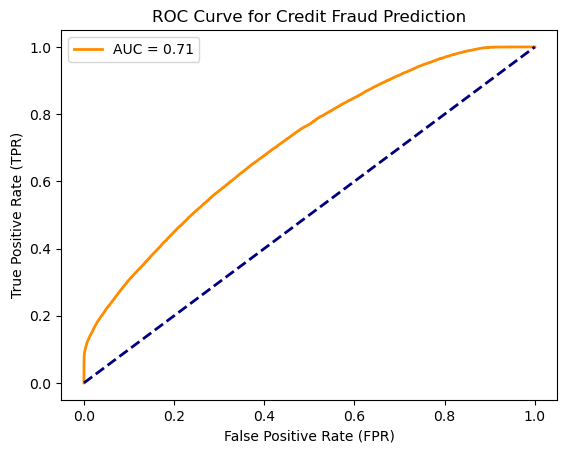

Area under curve (AUC):0.7083481576788944



In [16]:
# Regenerate scores
y_proba = fitted_search.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Credit Fraud Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

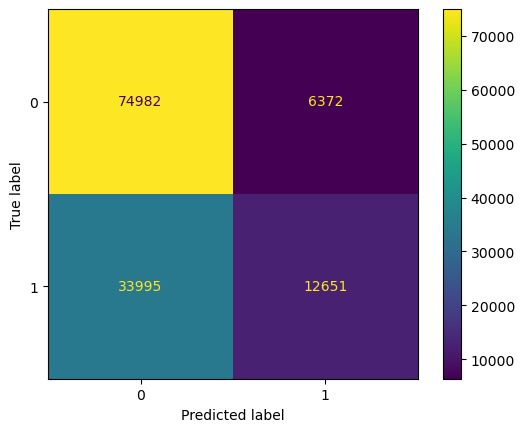

In [17]:
# evaluate on the original test set
y_pred = fitted_search.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [18]:
print("TEST SET")
print(classification_report(y_test, y_pred))

TEST SET
              precision    recall  f1-score   support

           0       0.69      0.92      0.79     81354
           1       0.67      0.27      0.39     46646

    accuracy                           0.68    128000
   macro avg       0.68      0.60      0.59    128000
weighted avg       0.68      0.68      0.64    128000



The AUC is 0.71, which is moderate. This indicates the model has some predictive capability but still has room for improvement. The curve is above the diagonal (random classifier) but does not show a steep increase near the top-left, indicating the model isn't exceptionally strong at separating classes.

The model is biased toward the majority class (0), as seen in its high recall for 0 and low recall for 1

Classification report
Accuracy: 68% – Not bad, but misleading due to class imbalance.
macro Avg F1-Score: 0.59 – Reflects the model's average performance across both classes, showing improvement is needed for the minority class.

## KNeighbors Classifier Ratings from 0 - 10

I will now test the K-Nearest Neighbors (KNN) model to evaluate its performance in predicting ratings on a scale of 0 to 10. This approach will help determine how well the data supports accurate predictions within this range.

To get the best values we are going to use a pipeline and a GridSearch

In [19]:
# Set X and y
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

# Pipeline with KNN
estimators = [
    ('normalise', StandardScaler()),
    ('reduce_dim', PCA()),
    ('knn', KNeighborsClassifier())
]

pipe = Pipeline(estimators)

# Parameter grid for grid search
params = {
    'knn__n_neighbors': [33, 35, 37],
    'reduce_dim__n_components': [29, 31, 33, 35]
}

# Perform the grid search
grid_searchKn = GridSearchCV(pipe, params, cv=5)

In [20]:
fitted_searchKn = grid_searchKn.fit(X_train, y_train)

In [21]:
# Best estimator object
fitted_searchKn.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('reduce_dim', PCA(n_components=33)),
                ('knn', KNeighborsClassifier(n_neighbors=35))])

In [22]:
# Best hyperparameters
fitted_searchKn.best_params_

{'knn__n_neighbors': 35, 'reduce_dim__n_components': 33}

In [23]:
# Mean test score for each CV fold
fitted_searchKn.cv_results_['mean_test_score']

array([0.65533854, 0.65555208, 0.65555729,        nan, 0.655375  ,
       0.6555625 , 0.65557292,        nan, 0.65528125, 0.65544271,
       0.65544271,        nan])

In [24]:
fitted_searchKn.score(X_train, y_train)

0.6585572916666667

In [25]:
fitted_searchKn.score(X_test, y_test)

0.656078125

The training and test scores are very close, suggesting no significant overfitting or underfitting. However, the overall accuracy is slightly lower than the logistic regression model (~68%). Mean test scores across CV folds are consistently around 65.5%, this consistency indicates that the model is stable and performs similarly across different subsets of the data.

### Evaluation

In [26]:
# evaluate on the original test set
y_pred = fitted_searchKn.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1","2","3","4","5","6","7","8","9","10"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

display(cf_df)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Predicted 10
True 0,81013,0,0,0,0,69,1,13,57,31,170
True 1,166,0,1,6,1,10,0,1,0,0,0
True 2,246,0,1,6,0,11,2,2,2,1,0
True 3,553,0,0,9,1,52,4,3,3,0,0
True 4,827,0,0,0,1,63,4,11,1,1,2
True 5,4879,0,0,0,0,556,14,70,47,3,8
True 6,3591,0,0,0,0,89,78,99,51,2,2
True 7,7394,0,0,0,1,29,17,410,211,21,25
True 8,10122,0,0,0,0,28,1,109,679,54,88
True 9,6702,0,0,0,0,7,3,26,179,280,196


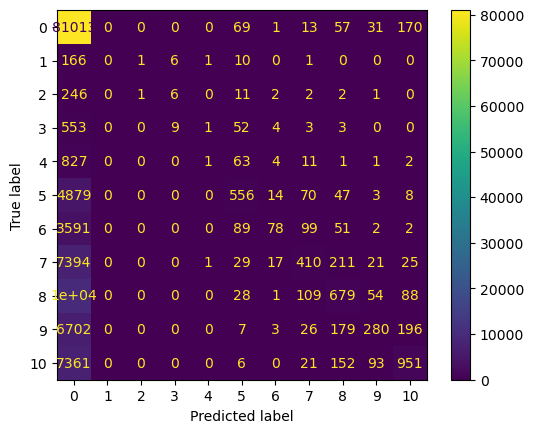

In [27]:
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [28]:
print("TEST SET")
print(classification_report(y_test, y_pred))

TEST SET
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     81354
           1       0.00      0.00      0.00       185
           2       0.50      0.00      0.01       271
           3       0.43      0.01      0.03       625
           4       0.25      0.00      0.00       910
           5       0.60      0.10      0.17      5577
           6       0.63      0.02      0.04      3912
           7       0.54      0.05      0.09      8108
           8       0.49      0.06      0.11     11081
           9       0.58      0.04      0.07      7393
          10       0.66      0.11      0.19      8584

    accuracy                           0.66    128000
   macro avg       0.48      0.13      0.14    128000
weighted avg       0.62      0.66      0.55    128000



These metrics show moderate performance overall but a noticeable bias toward the majority class (label 0). The model is heavily skewed toward predicting the majority class (0), achieving perfect recall for it while sacrificing performance on other classes.

Most minority classes (1 to 10) show extremely low recall, often close to 0%. This indicates the model struggles significantly to identify these classes.

All macro avg metrics reflect poor performance across all classes, indicating the model’s inability to handle the class imbalance effectively.

## KNeighbors Classifier Ratings from 0 - 1

In [29]:
# Set X and y
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

# Transform reviews to 0 and 1
y = y.apply(lambda x: 1 if 1 <= x <= 10 else x)

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

# Pipeline with KNN
estimators = [
    ('normalise', StandardScaler()),
    ('reduce_dim', PCA()),
    ('knn', KNeighborsClassifier())
]

pipe = Pipeline(estimators)

# Parameter grid for grid search
params = {
    'knn__n_neighbors': [75, 80, 85, 100 ],
    'reduce_dim__n_components': [23, 25, 27]
}

# Perform the grid search
grid_searchKn = GridSearchCV(pipe, params, cv=5)

In [30]:
fitted_searchKn = grid_searchKn.fit(X_train, y_train)

In [31]:
# Best estimator object
fitted_searchKn.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('reduce_dim', PCA(n_components=25)),
                ('knn', KNeighborsClassifier(n_neighbors=80))])

In [32]:
# Best hyperparameters
fitted_searchKn.best_params_

{'knn__n_neighbors': 80, 'reduce_dim__n_components': 25}

In [33]:
# Mean test score for each CV fold
fitted_searchKn.cv_results_['mean_test_score']

array([0.67939062, 0.68068229, 0.68054167, 0.68056771, 0.68179167,
       0.68049479, 0.68051042, 0.68156771, 0.68056771, 0.68106771,
       0.68146354, 0.68141146])

In [34]:
fitted_searchKn.score(X_train, y_train)

0.6911770833333334

In [35]:
fitted_searchKn.score(X_test, y_test)

0.68221875

The training and test accuracy are very close, indicating that the model generalizes well and is not overfitting. This performance is a slight improvement compared to the previous KNN model. The mean test scores across the folds range between 68.0% and 68.2%, which reflects stability in the model's performance during validation.

Test accuracy now matches the performance of logistic regression (~68%)

### Evaluation

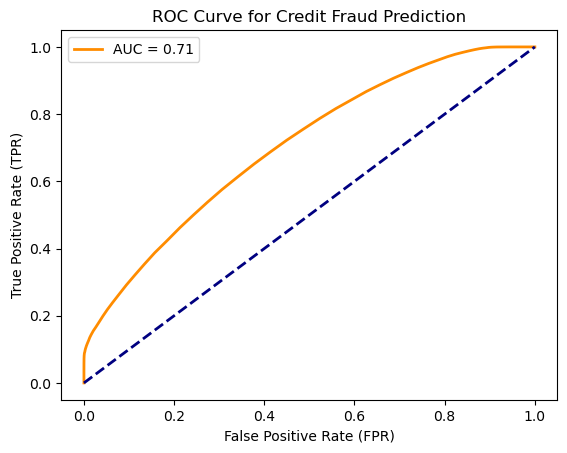

Area under curve (AUC):0.7056061846027076



In [36]:
# Regenerate scores
y_proba = fitted_searchKn.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Credit Fraud Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [37]:
# evaluate on the original test set
y_pred = fitted_searchKn.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

display(cf_df)

,Predicted 0,Predicted 1
True 0,75005,6349
True 1,34327,12319


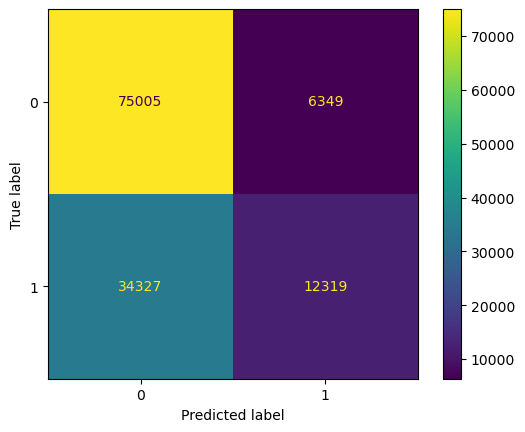

In [38]:
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [39]:
print("TEST SET")
print(classification_report(y_test, y_pred))

TEST SET
              precision    recall  f1-score   support

           0       0.69      0.92      0.79     81354
           1       0.66      0.26      0.38     46646

    accuracy                           0.68    128000
   macro avg       0.67      0.59      0.58    128000
weighted avg       0.68      0.68      0.64    128000



The AUC is 0.71, which is consistent with previous models. The curve is above the diagonal (random chance) but not significantly close to the top-left corner. This suggests the model does not achieve high sensitivity (true positive rate) without also increasing the false positive rate.

The model is still biased toward predicting the majority class (0), as evident from the large disparity in recall between class 0 (92%) and class 1 (26%).

Accuracy: 68% – Slightly better than random guessing but largely driven by the majority class.

So far Both the current KNN and Logistic Regression models achieve similar accuracy (~68%).

## Decision Tree Classifier ratings 0 - 10

In [40]:
# Set X and y
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

# Transform reviews to 0 and 1

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

estimators = [
              ('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier(random_state=20))
             ]

pipe = Pipeline(estimators)

param_grid = { 
              'reduce_dim__n_components': [6, 8, 10],
              'model__max_depth': [6,8, 10, 12],
              'model__min_samples_leaf': [6, 9, 12, 15],
              'model__min_samples_split': [1, 2, 3]
             }

gridDTC = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

In [41]:
fitted_searchDTC = gridDTC.fit(X_train, y_train)

In [42]:
# Best estimator object
fitted_searchDTC.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(n_components=8)),
                ('model',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=9,
                                        random_state=20))])

In [43]:
# Best hyperparameters
fitted_searchDTC.best_params_

{'model__max_depth': 8,
 'model__min_samples_leaf': 9,
 'model__min_samples_split': 2,
 'reduce_dim__n_components': 8}

In [44]:
# Mean test score for each CV fold
fitted_searchDTC.cv_results_['mean_test_score']

array([       nan,        nan,        nan, 0.65175   , 0.65944271,
       0.65944271, 0.65175   , 0.65944271, 0.65944271,        nan,
              nan,        nan, 0.65172396, 0.65943229, 0.65943229,
       0.65172396, 0.65943229, 0.65943229,        nan,        nan,
              nan, 0.65171354, 0.65941146, 0.65935937, 0.65171354,
       0.65941146, 0.65935937,        nan,        nan,        nan,
       0.65172396, 0.65941667, 0.65935937, 0.65172396, 0.65941667,
       0.65935937,        nan,        nan,        nan, 0.65273958,
       0.66003125, 0.65981771, 0.65273958, 0.66003125, 0.65981771,
              nan,        nan,        nan, 0.65273437, 0.66016146,
       0.65991146, 0.65273437, 0.66016146, 0.65991146,        nan,
              nan,        nan, 0.652875  , 0.65991667, 0.65970313,
       0.652875  , 0.65991667, 0.65970313,        nan,        nan,
              nan, 0.65286979, 0.659875  , 0.65972917, 0.65286979,
       0.659875  , 0.65972917,        nan,        nan,        

In [45]:
fitted_searchDTC.score(X_train, y_train)

0.66203125

In [46]:
fitted_searchDTC.score(X_test, y_test)

0.66003125

Both training and test accuracies are identical, which is a positive sign that the model is neither overfitting nor underfitting. However, the accuracy is similar compared to the tuned KNN model for ratings 0 to 10 (both ~65%).

### Evaluation

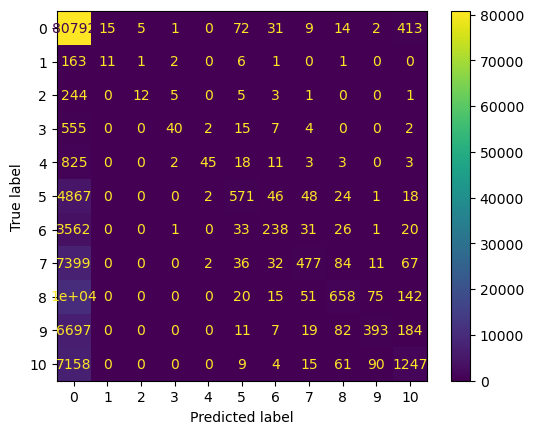

In [47]:
# evaluate on the original test set
y_pred = fitted_searchDTC.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1","2","3","4","5","6","7","8","9","10"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [48]:
print("TEST SET")
print(classification_report(y_test, y_pred))

TEST SET
              precision    recall  f1-score   support

           0       0.66      0.99      0.79     81354
           1       0.42      0.06      0.10       185
           2       0.67      0.04      0.08       271
           3       0.78      0.06      0.12       625
           4       0.88      0.05      0.09       910
           5       0.72      0.10      0.18      5577
           6       0.60      0.06      0.11      3912
           7       0.72      0.06      0.11      8108
           8       0.69      0.06      0.11     11081
           9       0.69      0.05      0.10      7393
          10       0.59      0.15      0.23      8584

    accuracy                           0.66    128000
   macro avg       0.68      0.15      0.18    128000
weighted avg       0.67      0.66      0.55    128000



There is considerable misclassification across minority classes, with many instances of these classes being misclassified as class 0.

Accuracy: 66% – Similar to training accuracy, indicating no overfitting.
Macro Average Recall: 0.15 – Highlights the model's inability to recall minority classes.
The model performs well in identifying class 0, with near-perfect recall (99%).

Compared with the KNN model, the Decision Tree had a higher macro average precision (68%) compared to KNN (48%). This indicates that the Decision Tree is better at reducing false positives across all classes.

## Decision Tree Classifier Ratings 0 - 1

In [49]:
# Set X and y
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

# Transform reviews to 0 and 1
y = y.apply(lambda x: 1 if 1 <= x <= 10 else x)

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

estimators = [
              ('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier(random_state=20))
             ]

pipe = Pipeline(estimators)

param_grid = { 
              'reduce_dim__n_components': [6, 8, 10, 12],
              'model__max_depth': [4, 6, 8],
              'model__min_samples_leaf': [1, 3, 6, 9],
              'model__min_samples_split': [3, 5, 7, 9]
             }

gridDTC = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

In [50]:
fitted_searchDTC = gridDTC.fit(X_train, y_train)

In [51]:
# Best estimator object
fitted_searchDTC.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(n_components=8)),
                ('model',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=9,
                                        min_samples_split=3,
                                        random_state=20))])

In [52]:
# Best hyperparameters
fitted_searchDTC.best_params_

{'model__max_depth': 8,
 'model__min_samples_leaf': 9,
 'model__min_samples_split': 3,
 'reduce_dim__n_components': 8}

In [53]:
# Mean test score for each CV fold
fitted_searchDTC.cv_results_['mean_test_score']

array([0.67448958, 0.67807813, 0.67807813, 0.67807813, 0.67448958,
       0.67807813, 0.67807813, 0.67807813, 0.67448958, 0.67807813,
       0.67807813, 0.67807813, 0.67448958, 0.67807813, 0.67807813,
       0.67807813, 0.67448958, 0.67807813, 0.67807813, 0.67807813,
       0.67448958, 0.67807813, 0.67807813, 0.67807813, 0.67448958,
       0.67807813, 0.67807813, 0.67807813, 0.67448958, 0.67807813,
       0.67807813, 0.67807813, 0.67448958, 0.67807813, 0.67807813,
       0.67807813, 0.67448958, 0.67807813, 0.67807813, 0.67807813,
       0.67448958, 0.67807813, 0.67807813, 0.67807813, 0.67448958,
       0.67807813, 0.67807813, 0.67807813, 0.67448958, 0.67807813,
       0.67807813, 0.67807813, 0.67448958, 0.67807813, 0.67807813,
       0.67807813, 0.67448958, 0.67807813, 0.67807813, 0.67807813,
       0.67448958, 0.67807813, 0.67807813, 0.67807813, 0.67614063,
       0.67801563, 0.67798438, 0.67795833, 0.67614063, 0.67801563,
       0.67798438, 0.67795833, 0.67614063, 0.67800521, 0.67797

In [54]:
fitted_searchDTC.score(X_train, y_train)

0.682890625

In [55]:
fitted_searchDTC.score(X_test, y_test)

0.680171875

Similar to the other models, the training and test accuracies are very close, indicating that the model generalizes well without overfitting.

Binary classification (0-1 target) is inherently easier for the Decision Tree to handle than multiclass classification (0-10), leading to better performance.

### Evaluation

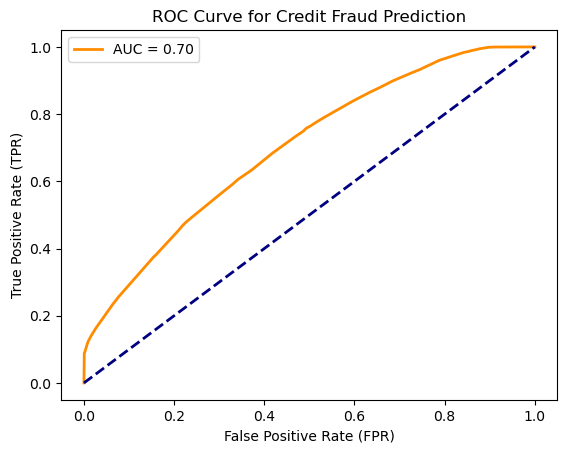

Area under curve (AUC):0.6999732608396695



In [56]:
# Regenerate scores
y_proba = fitted_searchDTC.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Credit Fraud Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

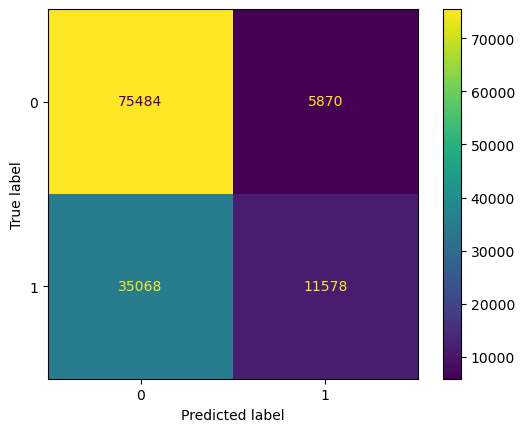

In [57]:
# evaluate on the original test set
y_pred = fitted_searchDTC.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [58]:
print("TEST SET")
print(classification_report(y_test, y_pred))

TEST SET
              precision    recall  f1-score   support

           0       0.68      0.93      0.79     81354
           1       0.66      0.25      0.36     46646

    accuracy                           0.68    128000
   macro avg       0.67      0.59      0.57    128000
weighted avg       0.68      0.68      0.63    128000



Moderate discrimination ability between the two classes
The Decision Tree has slightly lower accuracy than Logistic Regression and KNN. (68%)

High recall (93%) for class 0 ensures that most non-fraud cases are correctly identified.

## Summary

The performance of the models (Logistic Regression, KNN, and Decision Tree) is relatively similar in terms of results, with all achieving moderate accuracy (~68%) and comparable AUC values (0.70–0.71). However, none of the models adequately predict the data, particularly for the minority class, due to the significant class imbalance in the dataset.

All models show strong performance in identifying the majority class (0), with high recall values exceeding 90%. This reflects their ability to correctly classify non-fraud cases, which dominate the dataset. However, the recall for the minority class (1, representing fraud) is consistently low across all models.

While Logistic Regression slightly outperforms KNN and Decision Tree, the difference is marginal.